# Figure 5: Run duration minimizes the costs of movement and time.

## setup and imports

In [6]:
import fnmatch
import matplotlib.pyplot as plt
import numpy as np
import glob
import pickle
import warnings
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

from sessionlists import (dist60, dist90, dist120, TM20, TM10, TM2, TMrev2, TMrev10, TMrev20)
from utils import *
from plotting import *
from model_functions import *
from process_functions import compute_median_trajectory

plt.style.use('./Figures/paper.mplstyle')

In [7]:
# Define folder with data
root = "/home/thomas/Desktop/ALLDATA"

print("Path to data is: %s"%root)
print(f'Found {len(glob.glob(root+"/*"))} rats in the data folder')

Path to data is: /home/thomas/Desktop/ALLDATA
Found 34 rats in the data folder


In [8]:
rat_markers = {}
sequence = {}
params = {}
XtrackRunToLeftBin, XtrackRunToRightBin = {}, {}
trackTimeToLeftBin, trackTimeToRightBin = {}, {}
instantSpeedLeftBin, instantSpeedRightBin = {}, {}

TM1_pfPOS = [16.1, 97.3]
TM2_pfPOS = [17.2, 98.1]
TM1_virtualBoundary = [34.55, 80]  # in behav_params, should read_params(root, animal, session, "boundaryLeft")/11 ; read_params(root, animal, session, "boundaryRight")/11, but no change across sessions
TM2_virtualBoundary = [34.55, 80]


pfPOS = {'RatF00':TM1_pfPOS, 'RatF01':TM1_pfPOS, 'RatF02':TM1_pfPOS, 'RatF03':TM1_pfPOS, 
         'RatM00':TM2_pfPOS, 'RatM01':TM2_pfPOS, 'RatM02':TM2_pfPOS, 'RatM03':TM2_pfPOS}
virtualBoundary = {'RatF00':TM1_virtualBoundary, 'RatF01':TM1_virtualBoundary, 'RatF02':TM1_virtualBoundary, 'RatF03':TM1_virtualBoundary, 
                   'RatM00':TM2_virtualBoundary, 'RatM01':TM2_virtualBoundary, 'RatM02':TM2_virtualBoundary, 'RatM03':TM2_virtualBoundary}


# INTACT RATS
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43', 'RatM53', 'RatM54']


m, f = 0, 0
male_palette = create_teal_palette(num_shades=len([x for x in animalList if 'M' in x]))
female_palette = create_blue_violet_palette(num_shades=len([x for x in animalList if 'F' in x]), start_intensity=80)

for index, animal in enumerate(animalList):
    print(f'Loading data for {animal}')
    # define marker and color for each rat, used in plots
    if fnmatch.fnmatch(animal, 'RatF*'):
        rat_markers[animal]=[female_palette[f], 'o', ]
        f += 1
    elif fnmatch.fnmatch(animal, 'RatM*'):
        rat_markers[animal]=[male_palette[m], 'o', ]
        m += 1
    elif fnmatch.fnmatch(animal, 'Rat00*'):
        rat_markers[animal]=[(0.0, 0.0, 0.0), "$\u2426$",]
    else:
        print("error, this is not a rat you got here")

    # loop over all sessions for each rat and get the pickled preprocessed data. Data is processed in VIGOR_Preprocess.py
    # data (list or list of lists) for each variable is stored in a dictionary with keys (animal, session)
    for session in sorted(matchsession(animal, dist60+dist90+dist120 + TM20+TM10+TM2+TMrev2+TMrev10+TMrev20)):
        params[animal, session]     = get_from_pickle(root, animal, session, name="params.p")
        sequence[animal, session] = get_from_pickle(root, animal[0:6], session, name="sequence.p")
        XtrackRunToLeftBin[animal, session], XtrackRunToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackPos.p")
        trackTimeToLeftBin[animal, session], trackTimeToRightBin[animal, session] = get_from_pickle(root, animal, session, name="trackTime.p")
        instantSpeedLeftBin[animal, session],instantSpeedRightBin[animal, session]= get_from_pickle(root, animal, session, name="trackSpeed.p")      

Loading data for RatF00
Loading data for RatF01
Loading data for RatF02
Loading data for RatM00
Loading data for RatM01
Loading data for RatM02
Loading data for RatF32
Loading data for RatF33
Loading data for RatM31
Loading data for RatM32
Loading data for RatF42
Loading data for RatM40
Loading data for RatM43
Loading data for RatM53
Loading data for RatM54


# 5A Running speed profiles observed across distances
# 5B Running speed profiles observed across treadmill velocities
# 5C Rescaling

In [11]:
# utility plot functions

def plot_speed_profile(posdataRight, timedataRight, xylim,
                color, xyLabels=["", ""], ax=None):
    '''Plot speed profile for each run
    Args:
        posdataRight: list of lists, position data for each run
        timedataRight: list of lists, time data for each run
        xylim: list of 4 scalars, x and y limits for the plot
        color: list of 2 colors, color of the plot
        xyLabels: list of 2 strings, x and y labels for the plot
        ax: matplotlib axis object, if None, create a new figure and axis
    Returns:
        ax: matplotlib axis object
    '''
    if ax is None:
        ax = plt.gca()

    for pos, time in zip(posdataRight, timedataRight):
        t = np.subtract(time, time[0])
        abs_speed = [abs(_) for _ in pos]
        ax.plot(t, abs_speed, color=color, linewidth=0.1, alpha=0.5)

    ax.set_xlabel(xyLabels[0])
    ax.set_ylabel(xyLabels[1])
    ax.set_xlim([xylim[0], xylim[1]])
    ax.set_ylim([xylim[2], xylim[3]])
    return ax


# remove treadmill speed from speed profile
def removeTMspeed(datap, datas, TMspeed, 
                    pfPOS, virtualBoundary, k=.5):
    """remove treadmill speed between platform and virtual boundary
        for speed profiles in which the treadmill is on
    Args:
        datap: list of lists, position data for each run
        datas: list of lists, speed data for each run
        TMspeed: scalar, treadmill speed
        pfPOS: list of 2 scalars, platform position
        virtualBoundary: list of 2 scalars, virtual boundary position
        k: scalar, steepness of the function
    Returns:
        output: list of lists, corrected speed data for each run
    """
    def _correctTM(x, k=k, mu1=20, mu2=85, amp=20):
        """
        (approximation of the Heaviside function)
        Args:
            x: scalar, position 
            k: scalar, steepness of the function 
            mu1: scalar, start location, end of platform
            mu2: scalar, end location, virutal boundary location
            amp: scalar, height of the  function, treadmill speed
        Returns:
            p: scalar, f(x)
        """  
        LEFT = 1/(1+np.exp(-k*(x-mu1)))
        RIGHT = 1/(1+np.exp(k*(x-mu2)))
        return LEFT * RIGHT * amp

    output = copy.deepcopy(datas)

    if np.all([isinstance(dat, float) for dat in datap]):  # if only one run is available
        for j, (pos, speed) in enumerate(zip(datap, datas)):  # loop through time points in a run
            if datap[0] < datap[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
            elif datap[0] > datap[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                output[j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    else:
        for i, (positionarray, speedarray) in enumerate(zip(datap, datas)):  # loop through individual runs
            for j, (pos, speed) in enumerate(zip(positionarray, speedarray)):  # loop through time points in a run
                if positionarray[0] < positionarray[-1]:  # going to right, treadmill effect when not on left platform until right virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=pfPOS[0], mu2=virtualBoundary[1], amp=TMspeed)
                elif positionarray[0] > positionarray[-1]:  # going to left, treadmill effect when not on right platform until left virtual boundary
                    output[i][j] -= _correctTM(pos, k=k, mu1=virtualBoundary[0], mu2=pfPOS[1], amp=TMspeed)
    return output

# color code for conditions
condition_color_code = {'29 cm': plt.cm.get_cmap('bone')(0.8), '62 cm': plt.cm.get_cmap('bone')(0.65), '94 cm': plt.cm.get_cmap('bone')(.1),
                        '20 cm/s': plt.cm.get_cmap('summer')(0), '10 cm/s': plt.cm.get_cmap('summer')(.5), '± 2 cm/s': plt.cm.get_cmap('summer')(.9),
                        '- 10 cm/s': plt.cm.get_cmap('autumn')(.5), '- 20 cm/s': plt.cm.get_cmap('autumn')(0)}



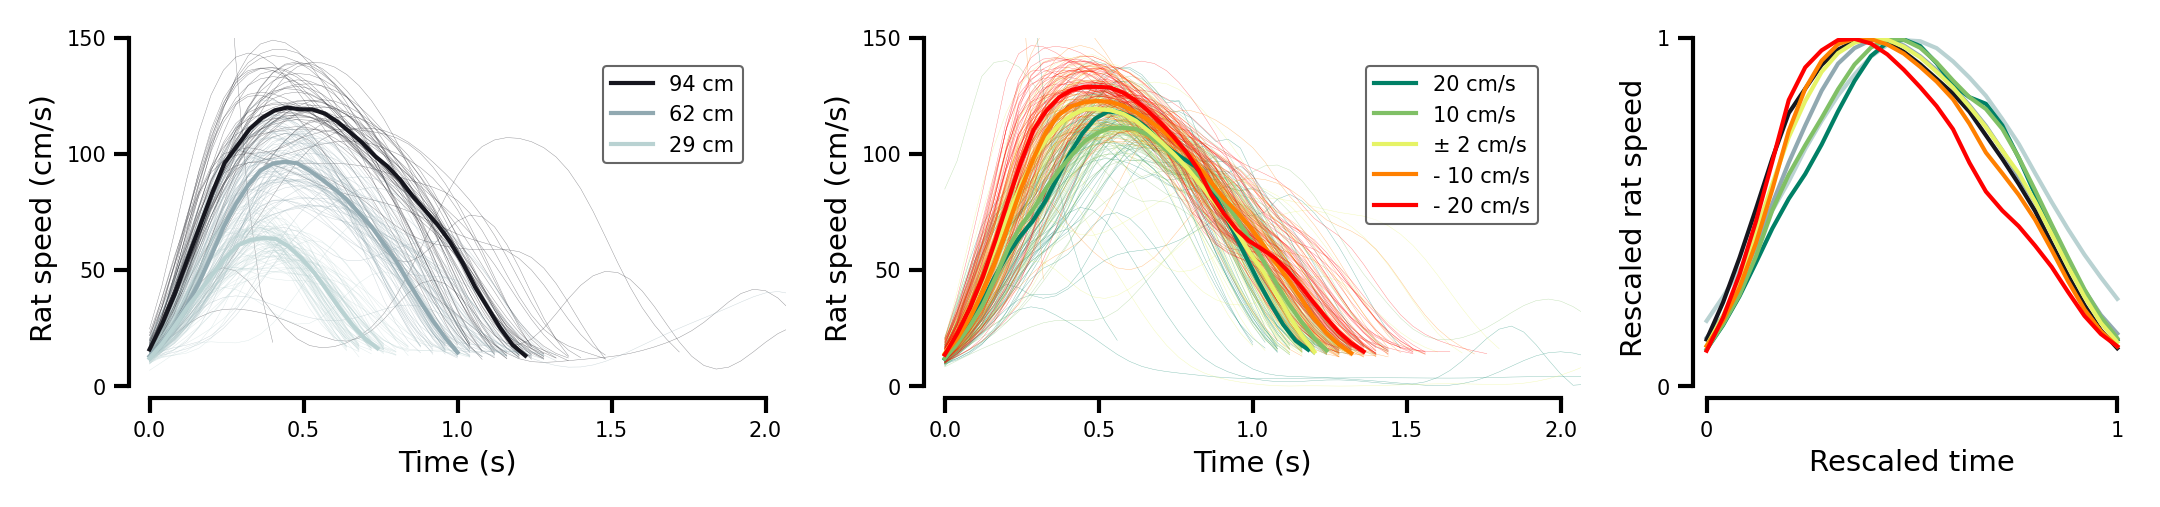

In [15]:
def Figure5A(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist120, dist90, dist60], ['94 cm', '62 cm', '29 cm']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname], 
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)
        
        ax.set_xticks([0, .5, 1, 1.5, 2])
        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='upper right', bbox_to_anchor=(0.95, 0.95),
                                frameon=True, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

def Figure5B(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([TM20, TM10, TM2, TMrev10, TMrev20], ['20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        # plot individual speed profiles
        plot_speed_profile(example_speed, example_time, 
                    xylim = [0, 2, 0, 150], color=condition_color_code[conditionname],
                    xyLabels=["Time (s)", "Rat speed (cm/s)"], ax=ax) 

        # plot median trajectory
        ax.plot(*compute_median_trajectory(example_speed, example_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

        handles, labels = ax.get_legend_handles_labels()
        unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
        ax.legend(*zip(*unique), loc='upper right', bbox_to_anchor=(0.95, 0.95),
                                frameon=True, fontsize=5,
                                edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)
        ax.set_xticks([0, .5, 1, 1.5, 2])
        ax.set_yticks([0, 50, 100, 150])
        space_axes(ax)

def Figure5C(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # example session
    animal = 'RatF01'  # sample animal
    index_session_example = -2  #last AM session
    index_block_example = 0 # first block

    for condition, conditionname in zip([dist60, dist90, dist120, TM20, TM10, TM2, TMrev10, TMrev20], 
    ['29 cm', '62 cm', '94 cm', '20 cm/s', '10 cm/s', '± 2 cm/s', '- 10 cm/s', '- 20 cm/s']):
        session = matchsession(animal, condition)[index_session_example]
        example_time = trackTimeToRightBin[animal, session][index_block_example]

        # keep treadmill speed for dist sessions
        if session in dist60+dist90+dist120:
            example_speed = instantSpeedRightBin[animal, session][index_block_example]
        
        # remove treadmill speed for TM sessions
        elif session in TM20+TM10+TM2+TMrev10+TMrev20:
            p = XtrackRunToRightBin[animal, session][index_block_example]
            s = instantSpeedRightBin[animal, session][index_block_example]
            t = trackTimeToRightBin[animal, session][index_block_example]
            tm_speed = params[animal, session]['treadmillSpeed'][index_block_example]
            example_speed = removeTMspeed(p, s, tm_speed, pfPOS[animal], virtualBoundary[animal])

        #rescale by average speed and movement time
        rescaled_time = copy.deepcopy(example_time)
        for i in range(len(example_time)):
            rescaled_time[i] = np.array(example_time[i])/(example_time[i][-1]-example_time[i][0])

        rescaled_speed = copy.deepcopy(example_speed)
        for i in range(len(example_speed)):
            # rescaled_speed[i] = np.array(example_speed[i])/np.nanmean(example_speed[i])
            rescaled_speed[i] = np.array(example_speed[i])/np.nanmax(example_speed[i])

        # plot median trajectory
        ax.plot(*compute_median_trajectory(rescaled_speed, rescaled_time), 
                    color=condition_color_code[conditionname], lw=1, alpha=1, zorder = 3, label=conditionname)

    ax.set_xlabel("Rescaled time")
    ax.set_ylabel("Rescaled rat speed")

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_yticks([0, 1])
    ax.set_xticks([0, 1])
    space_axes(ax)
    
fig, axs = plt.subplots(1, 3, figsize=(cm2inch(18), cm2inch(4)), dpi=300, gridspec_kw={'width_ratios': [1.5, 1.5, 1]})
Figure5A(axs[0])
Figure5B(axs[1])
Figure5C(axs[2])

# 5D Universal speed profile

Notation for a speed profile:  
- $t$: time  
- $T$: crossing time  
- $v(t)$: speed  
- $V_{\mathrm{max}}$: maximum speed  
- $v_{\mathrm{belt}}$: speed of the treadmill belt  

We can rescale the speed profile for each experimental condition:  
- $\tilde{t} = \frac{t}{T}$, rescaled time between 0-1  
- $\tilde{v}(\tilde{t}) = \frac{v(t)}{V_{\mathrm{max}}}$, rescaled speed between 0-1  

We notice that the speed profile is the same for each experimental condition (universal speed profile $\tilde{v}(\tilde{t})$), scaled in time and Vmax.  

The speed of the rat is:  
$v(t) = v_{\mathrm{belt}} + V_{\mathrm{max}} \tilde{v}(\tilde{t})$ &emsp;  with $\tilde{v}(\tilde{t})$ universal speed function  

When the rat travels a distance $D$ in time $T$ on a belt of speed $v_{\mathrm{belt}}$, the position $x$ of the rat is: 
$x(T) = D = v_{\mathrm{belt}}*T + V_{\mathrm{max}}T V_0 $   &emsp; with $V_0 = \int_0^1 \tilde{v}(\tilde{t})d\tilde{t}$ a constant  

This gives the following expression for $V_{\mathrm{max}}$:  
$V_{\mathrm{max}} = \frac{D-v_{\mathrm{belt}} T}{V_0 T}$  

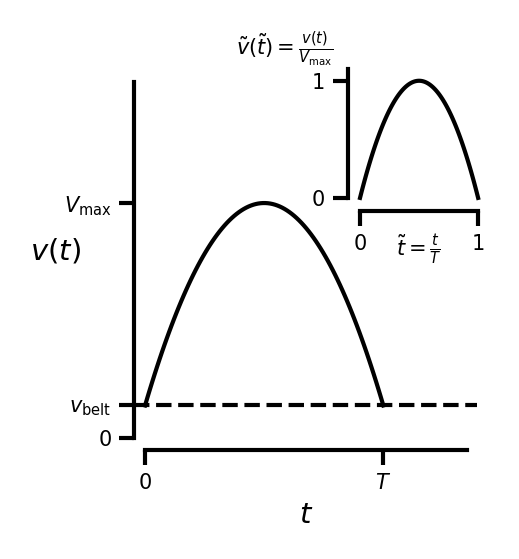

In [35]:
def Figure5D(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    # vbelt line
    VBELT = 0.2
    ax.axhline(VBELT, color='k', linestyle='--', lw=1)

    # parabola for speed profile
    def _simple_parabola(x, a, b, c):
        return a * x**2 + b * x + c

    y = _simple_parabola(np.linspace(0, 1, 100), -5, 5, VBELT)
    ax.plot(np.linspace(0, 1, 100), y, color='k', lw=1)
    VMAX = np.max(y)
    VMOY = np.mean(y)

    # labels and lims
    ax.set_xlabel(r'$t$')
    ax.set_ylabel(r'$v(t)$', rotation=0, loc='center')
    ax.set_xlim([0, 1.35])
    ax.set_ylim([0, 2.2])
    space_axes(ax)

    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, r'$T$'])
    ax.set_yticks([0, VBELT, VMAX])
    ax.set_yticklabels([0, r'$v_{\mathrm{belt}}$', r'$V_{\mathrm{max}}$'])


def Figure5Dbis(ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = 0

    # parabola for speed profile
    def _simple_parabola(x, a, b, c):
        return a * x**2 + b * x + c

    y = _simple_parabola(np.linspace(0, 1, 100), -5, 5, VBELT)
    ax.plot(np.linspace(0, 1, 100), y/np.max(y), color='k', lw=1)

    # labels and lims
    ax.set_xlabel(r'$\tilde{t} = \frac{t}{T}$', labelpad=-5, fontsize=5)
    ax.set_ylabel(r'$\tilde{v}(\tilde{t}) = \frac{v(t)}{V_{\mathrm{max}}}$', labelpad=-5, fontsize=5, rotation=0, loc='top')

    ax.set_xticks([0, 1])
    ax.set_xticklabels([0, 1])
    ax.set_yticks([0, 1])
    ax.set_yticklabels([0, 1])


    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.1)
    space_axes(ax, y_ratio=.1, x_ratio_left=.1, x_ratio_right=.1)


fig, ax = plt.subplots(1, 1, figsize=(cm2inch(4), cm2inch(4)))
Figure5D(ax=ax)

l, b, h, w = .7, .7, .3, 0.3
ax1 = fig.add_axes([l, b, w, h])
Figure5Dbis(ax=ax1)

# 5E Optimal run duration $T_{opt}$ minimizes $C = C_M + C_T$


In our model we assume that the total crossing cost is linear combination of an effort-related term and a time-related term:  

### Effort related term - Velocity cost
We assume that the effort-related cost $C_M$ is proportional to the kinetic energy (i.e., moving fast costs more energy). This cost is modulated by an effort sensitivity parameter, $\varsigma$. High values of $\varsigma$ correspond to a high effort sensitivity (i.e. the effort is perceived as larger). The cost $C_M$ of doing a movement of duration $T$ at speed $v$ on belt of speed $ v_{\mathrm{belt}}$ is:  

$C_M = \varsigma \int_0^T (v-v_{\mathrm{belt}})²dt$  
&emsp;&ensp; $= \varsigma V_{\mathrm{max}}^2 T V_1$ &emsp; with $V_1 = \int_0^1 \tilde{v}²(\tilde{t})d\tilde{t}$  

Replacing $V_{\mathrm{max}}$ yields:  
$C_M = \tilde{\varsigma} [\frac{d^2}{T}-2 d v_{\mathrm{belt}} + v_{\mathrm{belt}}^2 T]$  &emsp;with $\tilde{\varsigma} = \frac{\varsigma V_1}{V_0^2}$ a constant  

Without effort_sensitivity:  
$C_M = \sim [\frac{d^2}{T}-2 d v_{\mathrm{belt}} + v_{\mathrm{belt}}^2 T]$  
$C = \sim \varsigma C_M + C_T$  



### Time related cost - Time cost  
We assume that a cost linked to time increases as movement time $T$ increases.  
$C_T = T^{n}$  
For simplicity $n$ is fixed to $3$.


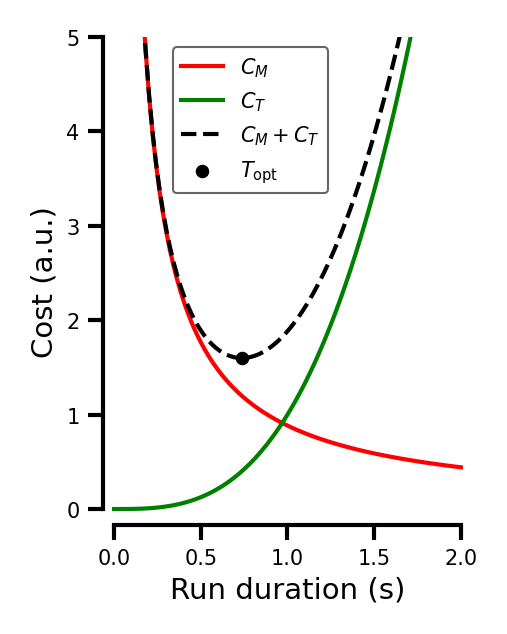

In [32]:
# effort cost for a movement of duration T, distance D, with a belt speed of vbelt
def effort_cost(T, D=1, effort_sensitivity=1, vbelt=0, power_effort=2):
    np.seterr(divide='ignore')
    # np.seterr(multiply='ignore')
    vmax = (D - vbelt * T) / (T)
    return effort_sensitivity * T * (vmax ** power_effort)

# time cost for a movement of duration T
def time_cost(T, tau=1, power_time=3):
    return tau * T ** power_time

def Topt(D, vbelt, effort_sensitivity):
    det = effort_sensitivity**2 * vbelt**4 + 12 * effort_sensitivity * D**2
    toptsquared = (np.sqrt(det) - (effort_sensitivity * vbelt**2)) / 6
    return np.sqrt(toptsquared)


def Figure5E(ax=None, D=.94, vbelt=0, effort_sensitivity=1, tau=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(16/4), 2))

    t = np.linspace(0, 2, 100)
    ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort), label=r'$C_M$', c='r')  # label=r'$C_M$, $\varsigma$=1, $\beta$=2'
    ax.plot(t, time_cost(t, tau, power_time), label=r'$C_T$', c='g')
    ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort) + time_cost(t, tau, power_time), label=r'$C_M + C_T$', c='k', ls='--')

    ax.scatter(Topt(D, vbelt, effort_sensitivity), effort_cost(Topt(D, vbelt, effort_sensitivity), D, effort_sensitivity, vbelt, power_effort) + time_cost(Topt(D, vbelt, effort_sensitivity), tau, power_time),
            color='k', s=5, label=r'$T_{\mathrm{opt}}$')

    ax.set_xlabel('Run duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper center', bbox_to_anchor=(0.4, 1), 
              frameon=True, fontsize=5, markerscale=1, 
              edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)

Figure5E()

# 5F Increasing ς increases $T_{opt}$

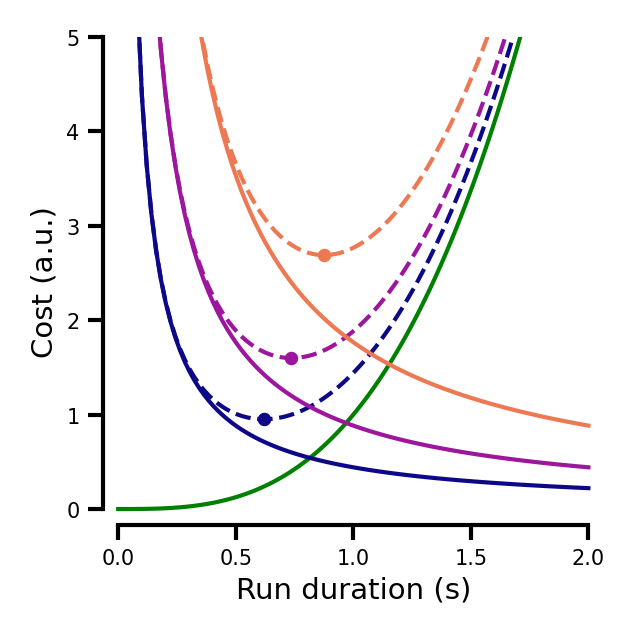

In [22]:

def Figure5F(ax=None, D=.94, vbelt=0, effort_sensitivity=1, tau=1, power_effort=2, power_time=3):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(2, 2))

    t = np.linspace(0, 2, 100)
    ax.plot(t, time_cost(t, tau, power_time), c='g')

    effort_sensitivitys = [0.5, 1, 2]
    cmap = plt.cm.get_cmap('plasma')

    for idx, effort_sensitivity in enumerate(effort_sensitivitys):
        e = r'$\varsigma$'
        ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort), c=cmap(idx/len(effort_sensitivitys)), label=f'{e} = {effort_sensitivity}')
        ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort) + time_cost(t, tau, power_time), c=cmap(idx/len(effort_sensitivitys)), ls='--')

        ax.scatter(Topt(D, vbelt, effort_sensitivity), 
                   effort_cost(Topt(D, vbelt, effort_sensitivity), D, effort_sensitivity, vbelt, power_effort) + time_cost(Topt(D, vbelt, effort_sensitivity), tau, power_time),
                   color=cmap(idx/len(effort_sensitivitys)), s=5)

    ax.set_xlabel('Run duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)


Figure5F()

# 5G  Increasing β also increases Topt.

In [23]:
def T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time):
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

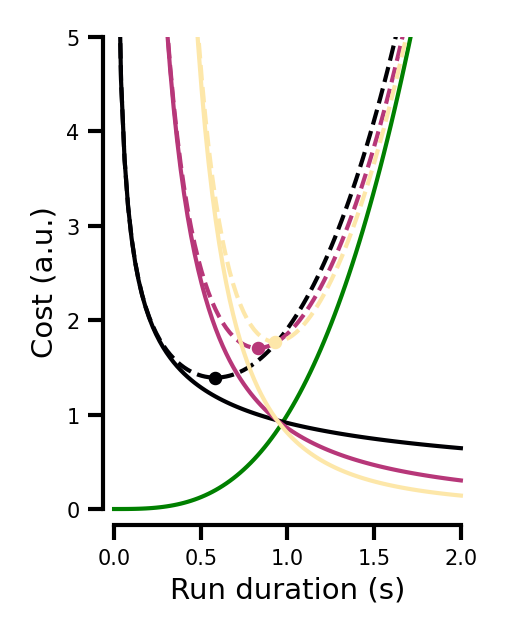

In [24]:
def Figure5G(ax=None, D=.94, vbelt=0, effort_sensitivity=1, tau=1, power_effort=2, power_time=3):

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(cm2inch(16/4), 2), dpi=300)

    t = np.linspace(0, 2, 100)
    ax.plot(t, time_cost(t, tau, power_time), c='g')

    for i, (power_effort, col) in enumerate(zip([1.5, 2.5, 3.5], [0, .5, .95])):
        beta = r'$\beta$'
        ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort), c=plt.cm.get_cmap('magma')(col), label=f'{beta} = {power_effort}', zorder=5+i)
        ax.plot(t, effort_cost(t, D, effort_sensitivity, vbelt, power_effort) + time_cost(t, tau, power_time), c=plt.cm.get_cmap('magma')(col), ls='--', zorder=5+i)

        ax.scatter(T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time),
                   effort_cost(T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time), D, effort_sensitivity, vbelt, power_effort) + time_cost(T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time), tau, power_time),
                   color=plt.cm.get_cmap('magma')(col), s=5, zorder=5+i)

    ax.set_xlabel('Run duration (s)')
    ax.set_ylabel('Cost (a.u.)')
    ax.set_ylim(0, 5)
    ax.set_xlim(0, 2)
    space_axes(ax)

Figure5G()

# 5HI Predictions of optimal run durations across distances and treadmill velocities
# 5JK same for running speed.


Total cost for a crossing is minimized when $\frac{C_M+C_T}{dT} = 0$  

We have:  

$\frac{dC_M}{dT} = \tilde{\varsigma} [\frac{-D^2}{T^2} + v_{\mathrm{belt}}^2]$  

and  

$\frac{dC_T}{dT} = nT^{n-1}$  

Therefore:  
$\frac{C_M+C_T}{dT} = \tilde{\varsigma} [\frac{-D^2}{T^2} + v_{\mathrm{belt}}^2] + nT^{n-1} = 0$  

Optimal crossing time $T_{\mathrm{opt}}$ for a movement of distance $D$, effort sensitivity $\varsigma$ on a belt of speed $v_{\mathrm{belt}}$ is:  
- for $n=1$:  
$T_{\mathrm{opt}} = \sqrt{\frac{\tilde{\varsigma}D²}{1 + \tilde{\varsigma}v_{\mathrm{belt}}^2}}$

- for $n=3$:  
$T_{\mathrm{opt}} = \sqrt{\frac{{-\tilde{\varsigma}v_{\mathrm{belt}}^2} + \sqrt{\tilde{\varsigma}²v_{\mathrm{belt}}^4 + 12\tilde{\varsigma}D²}}{6}}$  

The rat moves at speed $V_{\mathrm{opt}} = \frac{D}{T_{\mathrm{opt}}}$.

In [28]:
# compute optimal time for a given distance, belt speed, and reward size
# when time cost is T^1
def T_opt_n1(D, vbelt, effort_sensitivity):
    Tsq = (effort_sensitivity * D**2) / (1 + effort_sensitivity * vbelt**2)
    return np.sqrt(Tsq)

# when time cost is T^3
def T_opt_n3(D, vbelt, effort_sensitivity):
    det = np.sqrt(effort_sensitivity**2 * vbelt**4 + 12*effort_sensitivity*D**2)
    Tsq = ((det - (effort_sensitivity * vbelt**2)) / 6)
    return np.sqrt(Tsq)

def T_opt_n(D, vbelt, effort_sensitivity, power_effort, power_time):
    T = np.linspace(0.0, 2.5, 1000)
    vmax = (D - vbelt * T) / (T)
    cost = effort_sensitivity * T * vmax ** power_effort + T**power_time
    Topt = T[np.nanargmin(cost)]
    return Topt

animal = 'RatM00'
_, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/ModelsFitsAllRats.p", "rb"))
effort_sensitivity_0, effort_sensitivity_t, effort_sensitivity_R, power = pickle.load(open("picklejar/effort_sensitivity_fit.p", "rb"))
print(effort_sensitivity_0[animal], power[animal])

11.90239776690201 2.480711321097187


In [29]:
# compute the running distance for each run (pos start - pos end) for each distance configuration

realdist60 = {}
realdist90 = {}
realdist120= {}

animal = 'RatM00'

realdist60[animal], realdist90[animal], realdist120[animal] = ([] for _ in range(3))
for session in sorted(matchsession(animal, dist60)):
    for i in range(0, 12):
        realdist60[animal] = np.append(realdist60[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
        realdist60[animal] = np.append(realdist60[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
for session in sorted(matchsession(animal, dist90)):   
    for i in range(0, 12):
        realdist90[animal] = np.append(realdist90[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
        realdist90[animal] = np.append(realdist90[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])
for session in sorted(matchsession(animal, dist120)):
    for i in range(0, 12):
        realdist120[animal] = np.append(realdist120[animal], [abs(r[0] - r[-1]) for r in XtrackRunToRightBin[animal, session][i]])
        realdist120[animal] = np.append(realdist120[animal], [abs(l[0] - l[-1]) for l in XtrackRunToLeftBin[animal, session][i]])

# compute the mean running distance for each animal for each distance configuration
medianrealdist60 = {}
medianrealdist90 = {}
medianrealdist120 = {}


medianrealdist60[animal] = np.median(realdist60[animal]) / 100
medianrealdist90[animal] = np.median(realdist90[animal]) / 100
medianrealdist120[animal] = np.median(realdist120[animal]) / 100

print(medianrealdist60[animal], medianrealdist90[animal], medianrealdist120[animal])


0.2784055385810462 0.6108756721371416 0.9455853624351676


/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator


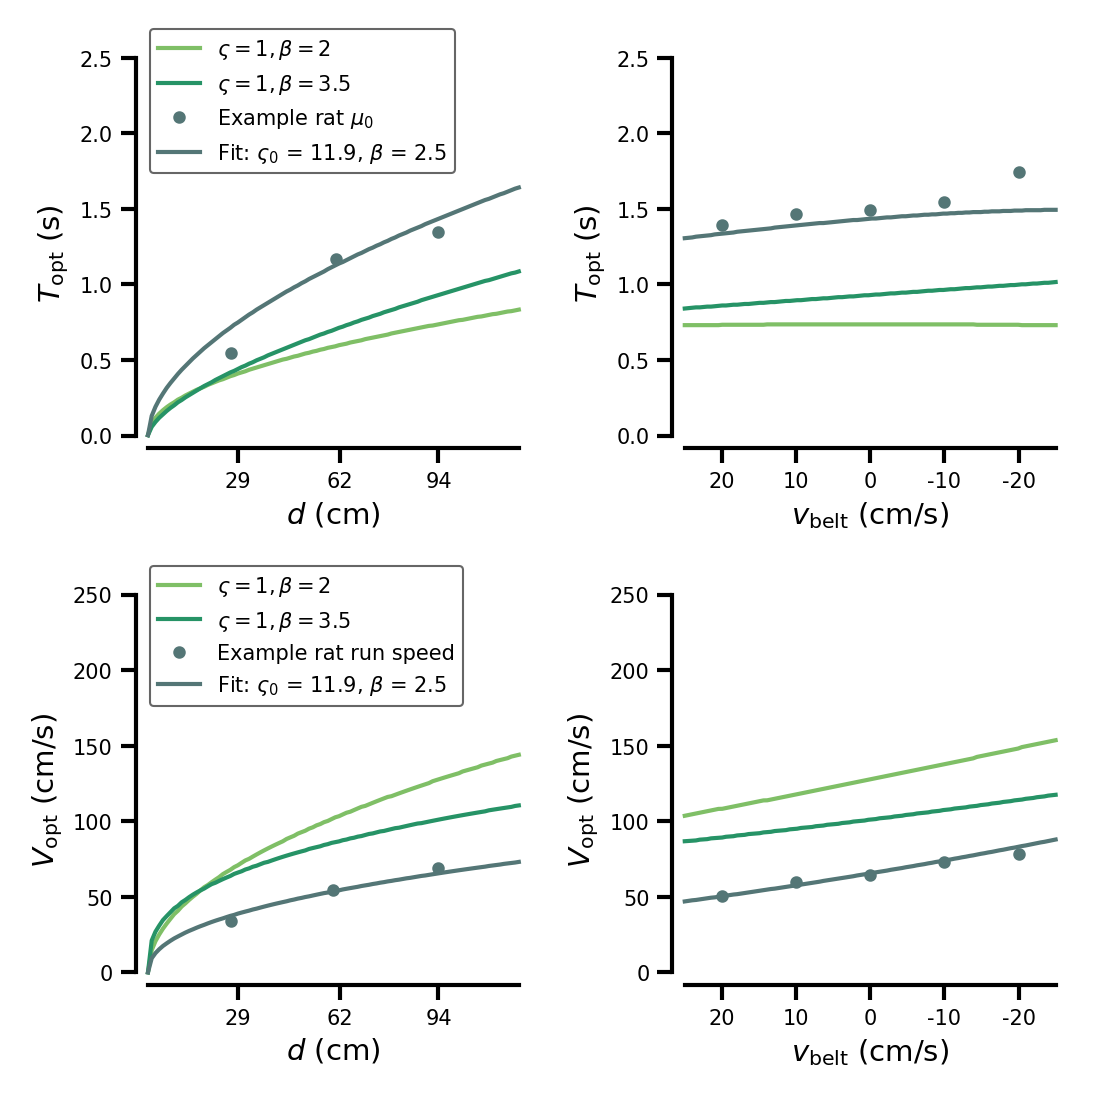

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(cm2inch(9), cm2inch(9)))

# Topt as a function of D
def Figure5H(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    ax.plot(D, [T_opt_n(d, Vbelt_cst, EFFORT_SENSITIVITY, 2, 3) for d in D], label=r'$\varsigma=1, \beta=2$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(D, [T_opt_n(d, Vbelt_cst, EFFORT_SENSITIVITY, 3.5, 3) for d in D], label=r'$\varsigma=1, \beta=3.5$', c=plt.get_cmap('summer_r')(0.85))

    rmu_0 = r'$\mu_0$'
    ax.plot([.27, .61, .94], [mu_0[animal]['60'], mu_0[animal]['90'], mu_0[animal]['120']], 
            color=rat_markers[animal][0], label=f'Example rat {rmu_0}', marker=rat_markers[animal][1],
            markersize=2, lw=0, zorder=10)

    beta = r'$\beta$'
    e = r'$\varsigma_0$'
    ax.plot(D, [T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3)for d in D], 
            label=f'Fit: {e} = {effort_sensitivity_0[animal]:.1f}, {beta} = {power[animal]:.1f}', c=rat_markers[animal][0])

    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel(r'$T_{\mathrm{opt}}$ (s)')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)



# Topt as a function of Vbelt
def Figure5I(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(.25, -.25, 100)
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, EFFORT_SENSITIVITY, 2, 3) for vbelt in VBELT], c=plt.get_cmap('summer_r')(0.5))
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, EFFORT_SENSITIVITY, 3.5, 3) for vbelt in VBELT], c=plt.get_cmap('summer_r')(0.85))

    ax.plot([.2, .1, 0, -.1, -.2], 
            [mu_0[animal]['20'], mu_0[animal]['10'], mu_0[animal]['2'], mu_0[animal]['rev10'], mu_0[animal]['rev20']], 
            color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(VBELT, [T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT], c=rat_markers[animal][0])
    
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel(r'$T_{\mathrm{opt}}$ (s)')
    ax.set_xlim(.25, -.25)
    ax.set_ylim(0, 2.5)
    ax.set_xticks([.2, .1, 0, -.1, -.2])
    ax.set_xticklabels([20, 10, 0, -10, -20])
    space_axes(ax)


# Vopt as a function of D
def Figure5J(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    D = np.linspace(0, 1.2, 100)
    ax.plot(D, [d/T_opt_n(d, Vbelt_cst, EFFORT_SENSITIVITY, 2, 3) for d in D], label=r'$\varsigma=1, \beta=2$', c=plt.get_cmap('summer_r')(0.5))
    ax.plot(D, [d/T_opt_n(d, Vbelt_cst, EFFORT_SENSITIVITY, 3.5, 3) for d in D], label=r'$\varsigma=1, \beta=3.5$', c=plt.get_cmap('summer_r')(0.85))

    speed60, speed90, speed120 = pickle.load(open("picklejar/example_rat_run_speeds_dist.p", "rb"))
    ax.plot([.27, .6, .94], [speed60/100, speed90/100, speed120/100], label=f'Example rat run speed',
            color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    
    beta = r'$\beta$'
    e = r'$\varsigma_0$'
    ax.plot(D, [d/T_opt_n(d, Vbelt_cst, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for d in D], 
            label=f'Fit: {e} = {effort_sensitivity_0[animal]:.1f}, {beta} = {power[animal]:.1f}', c=rat_markers[animal][0])


    _ = r'$d$'
    ax.set_xlabel(f'{_} (cm)')
    ax.set_ylabel(r'$V_{\mathrm{opt}}$ (cm/s)')
    ax.set_xlim(0, 1.2)
    ax.set_ylim(0, 2.5)
    ax.set_yticklabels([0, 0, 50, 100, 150, 200, 250])
    ax.set_xticks([.29, .62, .94])
    ax.set_xticklabels([29, 62, 94])
    space_axes(ax)

    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc='upper left', bbox_to_anchor=(0.01, 1.1), 
                            frameon=True, fontsize=5, markerscale=1, 
                            edgecolor='k', facecolor='w').get_frame().set_linewidth(.5)


# Vopt as a function of Vbelt
def Figure5K(ax=None, D_cst=.94, Vbelt_cst=0, EFFORT_SENSITIVITY=1):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))

    VBELT = np.linspace(.25, -.25, 100)
    ax.plot(VBELT, [D_cst/T_opt_n(D_cst, vb, EFFORT_SENSITIVITY, 2, 3) for vb in VBELT] - VBELT, c=plt.get_cmap('summer_r')(0.5))
    ax.plot(VBELT, [D_cst/T_opt_n(D_cst, vb, EFFORT_SENSITIVITY, 3.5, 3) for vb in VBELT] - VBELT, c=plt.get_cmap('summer_r')(0.85))

    animal = 'RatM00'
    speedrev20, speedrev10, speed2, speed10, speed20 = pickle.load(open("picklejar/example_rat_run_speeds_tm.p", "rb"))
    ax.plot([-.2, -.1, 0, .1, .2], [speed20/100, speed10/100, speed2/100, speedrev10/100, speedrev20/100], 
            color=rat_markers[animal][0], marker=rat_markers[animal][1], markersize=2, lw=0, zorder=10)
    ax.plot(VBELT, D_cst / np.array([T_opt_n(D_cst, vbelt, effort_sensitivity_0[animal], power_effort=power[animal], power_time=3) for vbelt in VBELT]) - VBELT, c=rat_markers[animal][0])
    
    _ = r'$v_{\mathrm{belt}}$'
    ax.set_xlabel(f'{_} (cm/s)')
    ax.set_ylabel(r'$V_{\mathrm{opt}}$ (cm/s)')
    ax.set_xlim(.25, -.25)
    ax.set_ylim(0, 2.5)
    ax.set_yticklabels([0, 0, 50, 100, 150, 200, 250])
    ax.set_xticks([.2, .1, 0, -.1, -.2])
    ax.set_xticklabels([20, 10, 0, -10, -20])
    space_axes(ax)


Figure5H(axs[0, 0])
Figure5I(axs[0, 1])
Figure5J(axs[1, 0])
Figure5K(axs[1, 1])

# Figure 5: Run duration minimizes the costs of movement and time.

/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:87: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/thomas/Documents/RunningFastAndSlow/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator


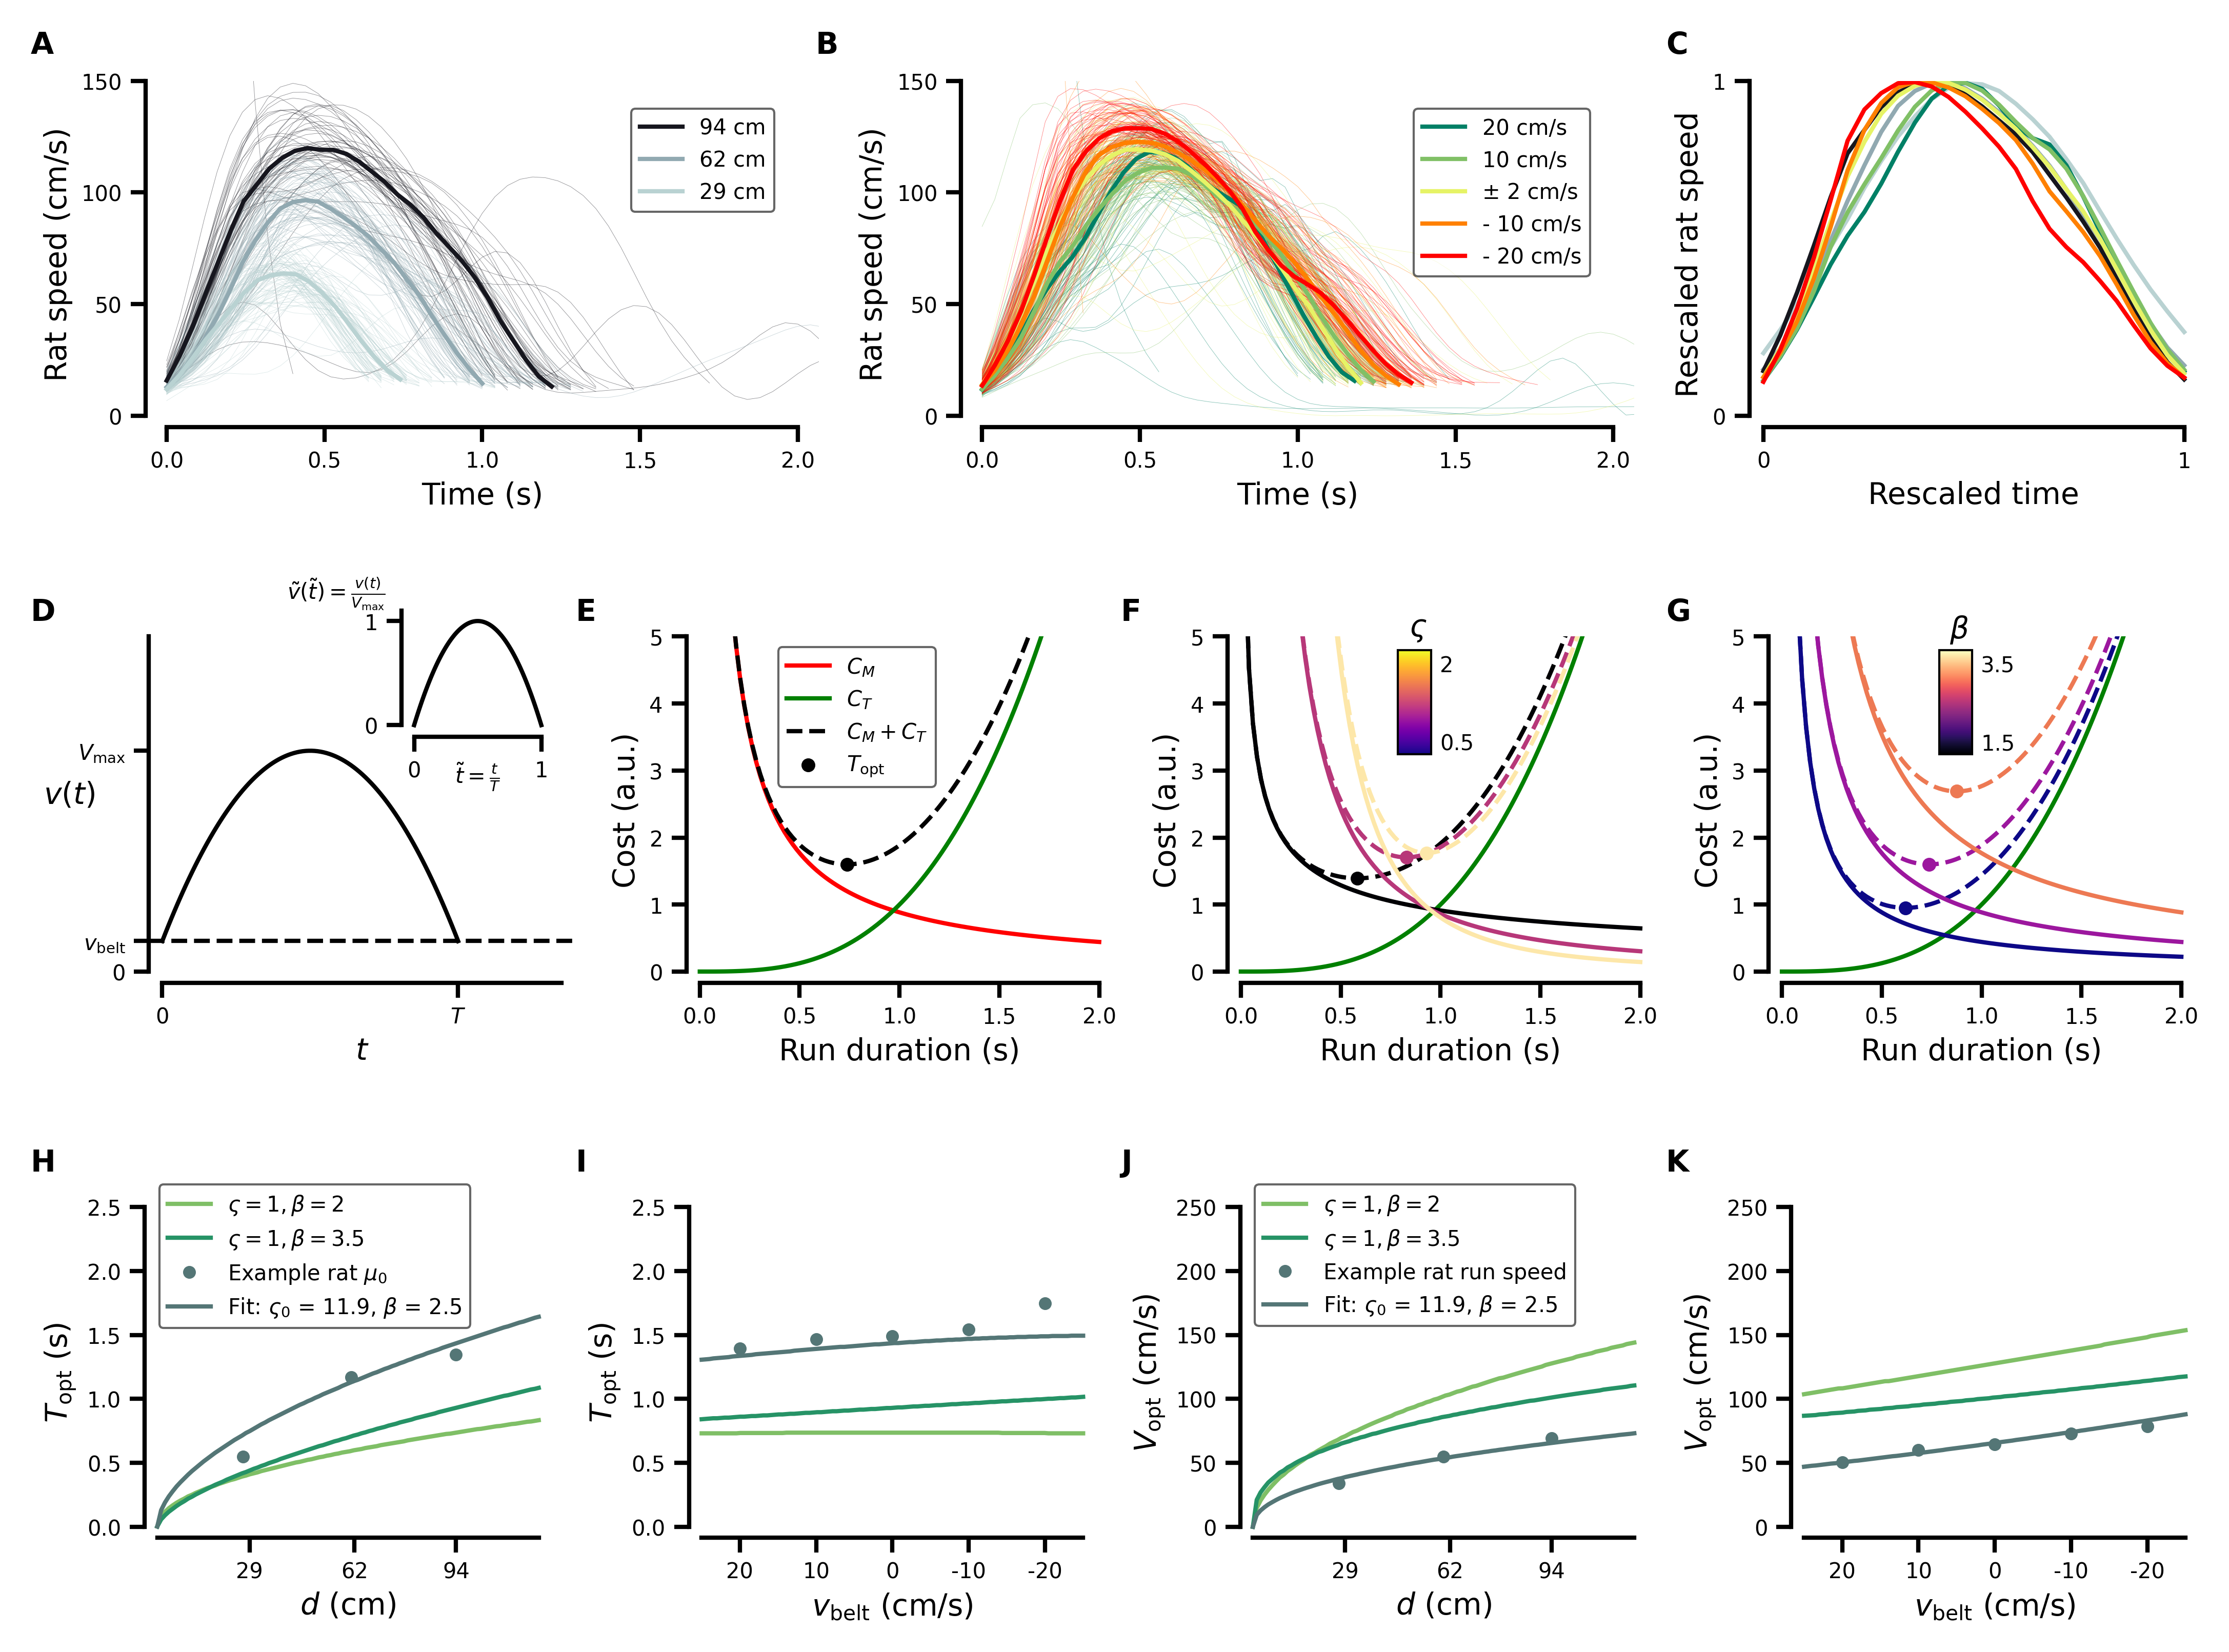

In [38]:
fig=plt.figure(figsize=(cm2inch(18), cm2inch(13)), dpi=600, constrained_layout=True, facecolor='w')

gs = fig.add_gridspec(5, 1 , hspace=0.5, height_ratios=[5, 1, 5, 1, 5])

row1 = gs[0].subgridspec(1, 3, wspace=.5, hspace=.5, width_ratios=[1.5, 1.5, 1])
ax_raw_dist = plt.subplot(row1[0])
ax_raw_vbelt = plt.subplot(row1[1])
ax_rawrescaled = plt.subplot(row1[2])

row2 = gs[2].subgridspec(1, 4, wspace=.5, hspace=.5, width_ratios=[1, 1, 1, 1])
ax_notation = plt.subplot(row2[0])
ax_model = plt.subplot(row2[1])
ax_effort_sensitivity_effect = plt.subplot(row2[2])
ax_beta_effect = plt.subplot(row2[3])

row3 = gs[4].subgridspec(1, 4, wspace=.5, hspace=.5, width_ratios=[1, 1, 1, 1])
our_model_Topt_D = plt.subplot(row3[0])
our_model_Topt_vbelt = plt.subplot(row3[1])
our_model_Vopt_D = plt.subplot(row3[2])
our_model_Vopt_vbelt = plt.subplot(row3[3])



Figure5A(ax_raw_dist)
Figure5B(ax_raw_vbelt)
Figure5C(ax_rawrescaled)

Figure5D(ax_notation)
Figure5E(ax_model)
Figure5F(ax_beta_effect)
Figure5G(ax_effort_sensitivity_effect)

Figure5H(our_model_Topt_D)
Figure5I(our_model_Topt_vbelt)
Figure5J(our_model_Vopt_D)
Figure5K(our_model_Vopt_vbelt)

# letter labels
figuresLabels={"A":[0.00, 1.00], "B":[0.36, 1.00], "C":[0.75, 1.00], 
               "D":[0.00, 0.64], "E":[0.25, 0.64], "F":[0.50, 0.64], "G":[0.75, 0.64],
                "H":[0.00, 0.29], "I":[0.25, 0.29], "J":[0.50, 0.29], "K":[0.75, 0.29]}

for label,coordinates in sorted(figuresLabels.items()):
    fig.text(coordinates[0], coordinates[1], label, figure=fig, 
            weight='bold', fontsize=7, ha='left', va='bottom')
    
# colorbars
fig.canvas.draw()
fig_axes = fig.axes
bounds = [_ax.get_position().bounds for _ax in fig_axes]
fig.set_constrained_layout(False)

plot_colorbar(ax_input=ax_effort_sensitivity_effect, x=.4, y=.66, width=.078, height=.3, 
              label=r'$\varsigma$', y_label=1.35, labelpad=-13, 
              cmap='plasma', labels=[.5, 0, 2])

plot_colorbar(ax_input=ax_beta_effect, x=.4, y=.66, width=.078, height=.3, 
              label=r'$\beta$', y_label=1.35, labelpad=-13, 
              cmap='magma', labels=[1.5, 0, 3.5])

for i, ax in enumerate(fig_axes):
    ax.set_position(bounds[i])
fig.canvas.draw()

# inset
lC, bC, hC, wC = 0.17, .57, 0.08, 0.07
ax1 = fig.add_axes([lC, bC, wC, hC])
Figure5Dbis(ax=ax1)


plt.savefig("./Figures_paper/Figure_5.pdf", facecolor='w', 
                edgecolor='none', bbox_inches='tight', format="pdf", dpi=600)

plt.savefig("./Figures_paper/Figure_5.svg", facecolor='w', 
        edgecolor='none', bbox_inches='tight', format="svg", dpi=600)